In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
import os
import numpy as np
import tensorflow as tf
import pickle
import gpflow
import soundfile
sys.path.append('../../')
import gpitch

In [3]:
visible_device = '0'  # gpu to use
namefile = os.listdir('../../../datasets/ss_amt/training_data/')  # files to analyze 
namefile = namefile
dataloc = '../../../datasets/ss_amt/training_data/'  # location of training data
gpitch.amtgp.init_settings(visible_device=visible_device, interactive=False)  # set gpu

Training using file ALVARADO_M60_train.wav and GPU 0
Training using file 311CLNOM_M60_train.wav and GPU 0
Training using file 311CLNOM_M67_train.wav and GPU 0
Training using file ALVARADO_M64_train.wav and GPU 0
Training using file ALVARADO_M67_train.wav and GPU 0
Training using file 011PFNOM_M67_train.wav and GPU 0
Training using file 311CLNOM_M64_train.wav and GPU 0
Training using file 011PFNOM_M64_train.wav and GPU 0
Training using file 131EGLPM_M64_train.wav and GPU 0
Training using file 131EGLPM_M60_train.wav and GPU 0
Training using file 011PFNOM_M60_train.wav and GPU 0
Training using file 131EGLPM_M67_train.wav and GPU 0


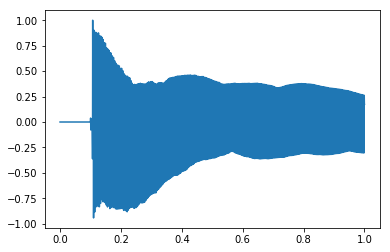

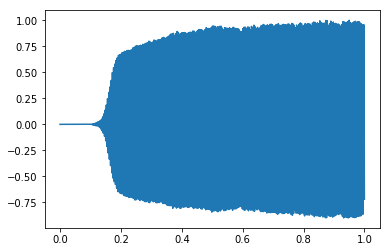

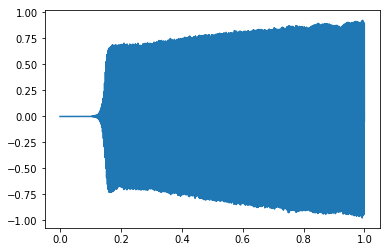

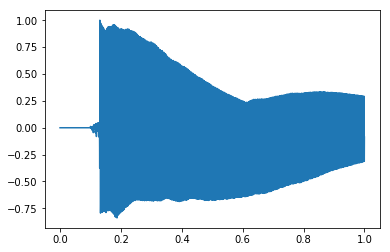

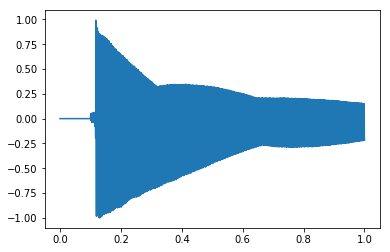

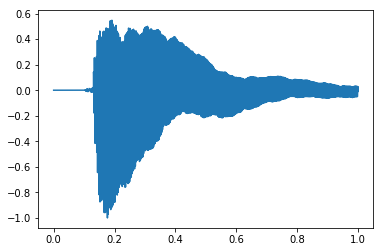

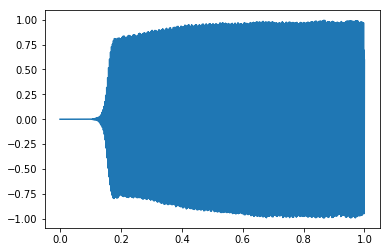

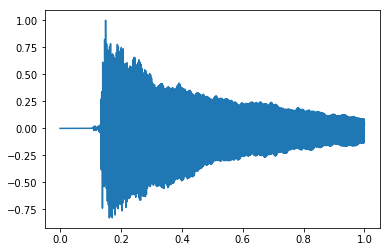

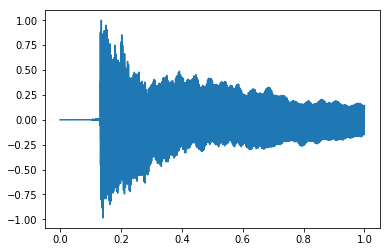

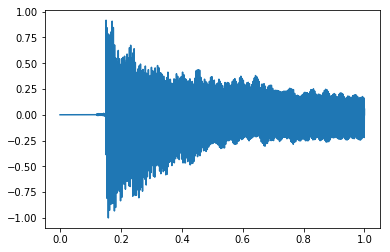

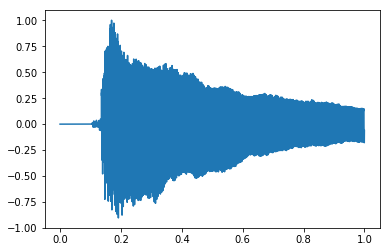

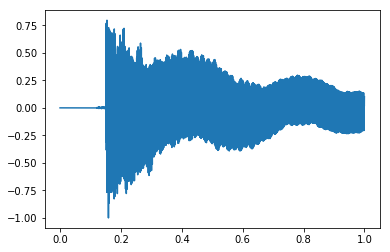

In [8]:
for i in range(12):
    audioname = dataloc + namefile[i]  # load data
    print('Training using file ' + namefile[i] + ' and GPU ' + visible_device)
    N = 16000  # number of frames
    dec = 160  # decimation factor
    minibatch_size = 200  # batch size svi
    maxiter = 2000  #  maximun number of iterations in optimization
    learning_rate = 0.01  # learning rate svi optimization
    maxh = 20  # max number of harmoncis in component kernel
    x, y, fs = gpitch.amtgp.readaudio(audioname, frames=N, start=0)  # load data
    ideal_f0 = gpitch.amtgp.find_ideal_f0(audioname)  # get ideal f0 from file name
    
    y_init = np.zeros((1600, 1))
    y_final = np.vstack((y_init, y[0:-1600]))
    
    plt.figure()
    plt.plot(x, y_final)
    icom = gpitch.amtgp.init_com_params(y=y, fs=fs, maxh=maxh, ideal_f0=ideal_f0, scaled=True,
                                        win_size=10)  # init component parameters
    Nc = icom[0].size  # number of harmonics per component

In [ ]:
ker_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=0.1, frequencies=icom[0],
                                       variances=icom[1], Nc=Nc)  # define comp kernel
ker_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=1., variance=10.)  # def act k
z = np.vstack((x[::dec].copy(), x[-1].copy()))
m = gpitch.modgp.ModGP(x=x, y=y, z=z, kern_com=ker_com, kern_act=ker_act, whiten=True,
                       minibatch_size=minibatch_size)
m.kern_com.fixed = True # Set all parameters free to optimize, but variances of component
m.kern_com.lengthscales.fixed = False
m.kern_com.lengthscales.transform = gpflow.transforms.Logistic(0., 10.0)
m.fixed_msmkern_params(freq=False, var=True)
m.kern_act.fixed = False
m.likelihood.variance.fixed = False
m.z.fixed = True

In [ ]:
m.optimize_svi(maxiter=maxiter, learning_rate=learning_rate)  # optimize

In [ ]:
W = 10
Nw = N / W
xnew = [x[Nw*i : Nw*(i+1)].copy() for i in range(W)]
prediction = m.predict_all(xnew)  # predict
m.prediction_save = prediction
pickle.dump(m, open('/import/c4dm-04/alvarado/results/ss_amt/trained_model_'
                    + namefile + ".p", "wb"))